In [1]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
import pandas as pd
import yfinance as yf
from stockstats import StockDataFrame
import yfinance as yf

# plot
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic", rc={'figure.figsize':(11,8)}) 
pd.options.display.float_format = '{:6.2f}'.format

/usr/local/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Valid start and end: YYYY-MM-DD
# Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
data = yf.download(
        tickers = "SOXL",
        period = "10y",
        interval = "1wk",
        group_by = 'ticker',
)

[*********************100%***********************]  1 of 1 completed


In [3]:
yfdata = data.copy().dropna()
yfdata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-14,0.51,0.52,0.41,0.41,0.39,146166000.00
2012-05-21,0.42,0.45,0.41,0.44,0.41,150258000.00
2012-05-28,0.45,0.47,0.38,0.38,0.35,107028000.00
2012-06-04,0.38,0.46,0.36,0.44,0.41,160974000.00
2012-06-11,0.45,0.46,0.41,0.44,0.41,124962000.00
...,...,...,...,...,...,...
2022-04-18,25.26,30.85,24.37,24.45,24.45,257770100.00
2022-04-25,23.89,26.30,21.48,22.24,22.24,277146300.00
2022-05-02,22.38,28.14,21.81,23.35,23.35,325651000.00


In [4]:
def convert_df_to_stock_df(df: pd.DataFrame) -> StockDataFrame:
    sdf = df.copy()
    sdf.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'amount',
        'Volume': 'volume',
    }, inplace=True)
    sdf.index.names = ['date']
    return StockDataFrame(sdf)

def SMA(arr: pd.DataFrame, n: int) -> pd.Series:
    samsdf = convert_df_to_stock_df(arr)
    sma = samsdf['close_'+str(n)+'_sma']
    return sma

In [7]:
class SmaCross(Strategy):
    n1 = 20
    n2 = 55

    def init(self):
        self.sma1 = self.I(SMA, self.data.df, self.n1)
        self.sma2 = self.I(SMA, self.data.df, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
            
bt = Backtest(yfdata,
              SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
print(output)
bt.plot()

#最適化
optimize=bt.optimize(n1=range(10, 70, 5), n2=range(10, 70, 5), maximize='Equity Final [$]')
print(optimize)
print(optimize._strategy)

Start                     2012-05-14 00:00:00
End                       2022-05-13 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                       93.50
Equity Final [$]                     53971.48
Equity Peak [$]                     165058.04
Return [%]                             439.71
Buy & Hold Return [%]                 5338.94
Return (Ann.) [%]                      125.31
Volatility (Ann.) [%]                 1533.47
Sharpe Ratio                             0.08
Sortino Ratio                            1.04
Calmar Ratio                             1.40
Max. Drawdown [%]                      -89.30
Avg. Drawdown [%]                      -17.97
Max. Drawdown Duration      823 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                    9
Win Rate [%]                            55.56
Best Trade [%]                         321.35
Worst Trade [%]                        -59.59
Avg. Trade [%]                    

Start                     2012-05-14 00:00:00
End                       2022-05-13 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                       93.50
Equity Final [$]                     53971.48
Equity Peak [$]                     165058.04
Return [%]                             439.71
Buy & Hold Return [%]                 5338.94
Return (Ann.) [%]                      125.31
Volatility (Ann.) [%]                 1533.47
Sharpe Ratio                             0.08
Sortino Ratio                            1.04
Calmar Ratio                             1.40
Max. Drawdown [%]                      -89.30
Avg. Drawdown [%]                      -17.97
Max. Drawdown Duration      823 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                    9
Win Rate [%]                            55.56
Best Trade [%]                         321.35
Worst Trade [%]                        -59.59
Avg. Trade [%]                    

<Figure size 792x576 with 0 Axes>

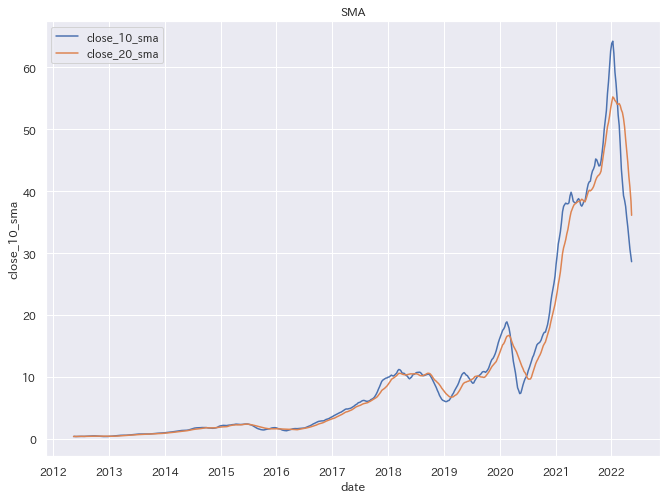

<Figure size 792x576 with 0 Axes>

In [6]:
plot_df = pd.DataFrame(SMA(yfdata, 10)).join(SMA(yfdata, 20))
sns.lineplot(data = plot_df, x='date', y='close_10_sma').set_title('SMA')
sns.lineplot(data = plot_df, x='date', y='close_20_sma')
plt.legend(labels=["close_10_sma","close_20_sma"])
plt.figure()